# Intro to Graph Neural Networks (GNN)

The goal of this notebook is to give you an idea how GNNs work in practice. To this end, a prototypical molecular graph will be constructed, after which a full GNN will be constructed.

### Relevant packages: Pytorch Geometric (PyG)
PyG is a library built upon PyTorch to easily write and train Graph Neural Networks (GNNs) for a wide range of applications related to structured data. You can also browse its [documentation](https://pytorch-geometric.readthedocs.io/en/latest/) for additional details.

In [25]:
# Install all libraries
# CoLab has already preinstalled Pytorch for you
! pip install pytorch-lightning wandb rdkit ogb
# install PyG
! pip install torch_geometric

Set a random seed to ensure repeatability of experiments

In [26]:
import random
import numpy as np
import torch

# Random Seeds and Reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)

### Molecular graph
A [molecular graph](https://en.wikipedia.org/wiki/Molecular_graph) is a labeled graph whose nodes correspond to the atoms of the compound and edges correspond to chemical bonds. It also has node features (**atom features**), edge features (**bond features**) and graph labels (chemical properties of a molecule). Here, we demonstrate a simple example of building a molecular graph (undirected). Note that we do not consider hydrogen atoms as nodes.

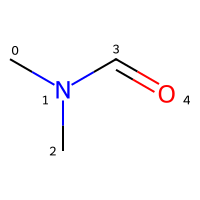

In [27]:
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

IPythonConsole.ipython_useSVG = True  # < use SVGs instead of PNGs
IPythonConsole.drawOptions.addAtomIndices = True  # adding indices for atoms
IPythonConsole.drawOptions.addBondIndices = False  # not adding indices for bonds
IPythonConsole.molSize = 200, 200

# N,N-dimethylformamide (DMF)
dmf_smiles = 'CN(C)C=O'
mol = MolFromSmiles(dmf_smiles)
# show molecular graph of DMF, atom indices = node indices
mol

### Atom features

| feature | description |
| ---- | ----  |
| atom type  | atomic number |
| degree  | number of directly-bonded neighbor atoms, including H atoms |
| formal charge | integer electronic charge assigned to atom |
| hybridization | sp, sp2, sp3, sp3d, or sp3d2 |

In [28]:
ATOM_FEATURES = {
    'atom_type' : [1, 6, 7, 8, 9],  # elements: H, C, N, O, F
    'degree' : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'misc'],
    'formal_charge' : [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 'misc'],
    'hybridization' : [
        'SP', 'SP2', 'SP3', 'SP3D', 'SP3D2', 'misc'
        ],
}

def get_atom_fv(atom):
    """
    Converts rdkit atom object to feature list of indices
    :param atom: rdkit atom object
    :return: list
    """
    atom_fv = [
        ATOM_FEATURES['atom_type'].index(atom.GetAtomicNum()),
        ATOM_FEATURES['degree'].index(atom.GetTotalDegree()),
        ATOM_FEATURES['formal_charge'].index(atom.GetFormalCharge()),
        ATOM_FEATURES['hybridization'].index(str(atom.GetHybridization())),
    ]
    return atom_fv

atom_fvs = [get_atom_fv(atom) for atom in mol.GetAtoms()]
atom_fvs

[[1, 4, 5, 2], [2, 3, 5, 1], [1, 4, 5, 2], [1, 3, 5, 1], [3, 1, 5, 1]]

### Bond features

| feature | description |
| ---- | ----  |
| bond type  | single, double, triple, or aromatic |
| stereo | none, any, E/Z or cis/trans |
| conjugated  | whether the bond is conjugated |

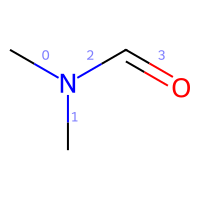

In [29]:
# Show indices of bonds
IPythonConsole.drawOptions.addAtomIndices = False  # not adding indices for atoms
IPythonConsole.drawOptions.addBondIndices = True  # adding indices for bonds
mol

In [30]:
BOND_FEATURES = {
    'bond_type' : [
        'SINGLE',
        'DOUBLE',
        'TRIPLE',
        'AROMATIC',
        'misc'
    ],
    'stereo': [
        'STEREONONE',
        'STEREOZ',
        'STEREOE',
        'STEREOCIS',
        'STEREOTRANS',
        'STEREOANY',
    ],
    'conjugated': [False, True],
}

def get_bond_fv(bond):
    """
    Converts rdkit bond object to feature list of indices
    :param bond: rdkit bond object
    :return: list
    """
    bond_fv = [
        BOND_FEATURES['bond_type'].index(str(bond.GetBondType())),
        BOND_FEATURES['stereo'].index(str(bond.GetStereo())),
        BOND_FEATURES['conjugated'].index(bond.GetIsConjugated()),
    ]
    return bond_fv

bond_fvs = [get_bond_fv(bond) for bond in mol.GetBonds()]
bond_fvs

[[0, 0, 0], [0, 0, 0], [0, 0, 1], [1, 0, 1]]

### Edge index
In many cases, a list of paired node indices are used to describe edges rather than adjacency matrix. Here we use paired node indices (`edge_index`) with shape (2, num_edges) to define the edges in a graph.

$$
\mathbf{E} = \begin{bmatrix}
    ..., & i, & ..., & j, & ... \\
    ..., & j, & ..., & i, & ...
\end{bmatrix}
$$
So, from the paired node indices list, we can conclude that there has an edge between node $i$ and node $j$ (undirected graph).


In [31]:
edge_index0, edge_index1 = [], []

for bond in mol.GetBonds():
    i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
    edge_index0 += [i, j]
    edge_index1 += [j, i]

edge_index = [edge_index0, edge_index1]
edge_index

[[0, 1, 1, 2, 1, 3, 3, 4], [1, 0, 2, 1, 3, 1, 4, 3]]

### Molecular graph data

We set the density of DMF(0.944 $g/cm^3$) as the graph feature (label). Here we use [Data](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html#torch_geometric.data.Data) class in `PyG` to create a graph data for DMF.

In [32]:
import torch
from torch_geometric.data import Data

# convert our data to tensors, which are used for model training
x = torch.tensor(atom_fvs, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long)
edge_attr = torch.tensor(bond_fvs, dtype=torch.float)
y = torch.tensor([0.944], dtype=torch.float)

dmf_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
dmf_data

Data(x=[5, 4], edge_index=[2, 8], edge_attr=[4, 3], y=[1])

## Graph Neural Network

A [graph neural network (GNN)](https://en.wikipedia.org/wiki/Graph_neural_network) is a class of artificial neural networks for processing data that can be represented as graphs. GNNs rely on [message passing methods](https://arxiv.org/abs/1704.01212), which means that nodes exchange information with the neighbors, and send "messages" to each other. Generally, GNNs operate in two phases: a **message passing** phase, which transmits information across the molecule to build a neural representation of the molecule, and a **readout** phase, which uses the final representation of the molecule to make predictions about the properties of interest.

Here, we will define a GNN model using message passing neural network (MPNN) according to paper ["Neural Message Passing for Quantum Chemistry"](https://arxiv.org/abs/1704.01212). We just use [NNConv](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.NNConv.html#torch_geometric.nn.conv.NNConv) class to create message passing layers of our models (the various steps outlined in the lecture, i.e., 'send messages' + 'message aggregation' + 'node update' all happen under the hood inside this class). The [torch_geometric.nn](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html) module of PyG contains many different types of layers for message passing and readout, which can help us define GNN models more conveniently.

In [33]:
import torch
import torch.nn.functional as F
from torch.nn import GRU
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, MLP, global_add_pool
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder


class MPNN(pl.LightningModule):
    def __init__(self, hidden_dim, out_dim,
                 train_data, valid_data, test_data,
                 std, batch_size=32, lr=1e-3):
        super().__init__()
        self.std = std  # std of data's target
        self.train_data = train_data
        self.valid_data = valid_data
        self.test_data = test_data
        self.batch_size = batch_size
        self.lr = lr
        # Initial layers
        self.atom_emb = AtomEncoder(emb_dim=hidden_dim)
        self.bond_emb = BondEncoder(emb_dim=hidden_dim)
        # Message passing layers
        nn = MLP([hidden_dim, hidden_dim*2, hidden_dim*hidden_dim])
        self.conv = NNConv(hidden_dim, hidden_dim, nn, aggr='mean')
        self.gru = GRU(hidden_dim, hidden_dim)
        # Readout layers
        self.mlp = MLP([hidden_dim, int(hidden_dim/2), out_dim])

    def forward(self, data, mode="train"):

        # Initialization
        x = self.atom_emb(data.x)
        h = x.unsqueeze(0)
        edge_attr = self.bond_emb(data.edge_attr)

        # Message passing
        for i in range(3):
            m = F.relu(self.conv(x, data.edge_index, edge_attr))  # send message and aggregation
            x, h = self.gru(m.unsqueeze(0), h)  # node update
            x = x.squeeze(0)

        # Readout
        x = global_add_pool(x, data.batch)
        x = self.mlp(x)

        return x.view(-1)

    def training_step(self, batch, batch_idx):
        # Here we define the train loop.
        out = self.forward(batch, mode="train")
        loss = F.mse_loss(out, batch.y)
        self.log("Train loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        # Define validation step. At the end of every epoch, this will be executed
        out = self.forward(batch, mode="valid")
        loss = F.mse_loss(out * self.std, batch.y * self.std)  # report MSE
        self.log("Valid MSE", loss)

    def test_step(self, batch, batch_idx):
        # What to do in test
        out = self.forward(batch, mode="test")
        loss = F.mse_loss(out * self.std, batch.y * self.std)  # report MSE
        self.log("Test MSE", loss)

    def configure_optimizers(self):
        # Here we configure the optimization algorithm.
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.lr
        )
        return optimizer

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.valid_data, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size, shuffle=False)

Here, we can use [InMemoryDataset]() class in PyG to create the graph dataset of ESOL conveniently. You can also browse its [tutorial](https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html) and [pre-defined dataset](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html) to learn about how to create graph datasets quickly by PyG.

In [34]:
from tqdm import tqdm
import pandas as pd
import torch
from torch_geometric.data import (
    Data,
    InMemoryDataset,
    download_url,
)
from ogb.utils import smiles2graph


class ESOLGraphData(InMemoryDataset):
    """The ESOL graph dataset using PyG
    """
    # ESOL dataset download link
    raw_url = 'https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv'

    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def raw_file_names(self):
        return ['delaney-processed.csv']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        print('Downloading ESOL dataset...')
        file_path = download_url(self.raw_url, self.raw_dir)

    def process(self):
        # load raw data from a csv file
        df = pd.read_csv(self.raw_paths[0])
        smiles = df['smiles'].values.tolist()
        target = df['measured log solubility in mols per litre'].values.tolist()

        # Convert SMILES into graph data
        print('Converting SMILES strings into graphs...')
        data_list = []
        for i, smi in enumerate(tqdm(smiles)):

            # get graph data from SMILES
            graph = smiles2graph(smi)

            # convert to tensor and pyg data
            x = torch.tensor(graph['node_feat'], dtype=torch.long)
            edge_index = torch.tensor(graph['edge_index'], dtype=torch.long)
            edge_attr = torch.tensor(graph['edge_feat'], dtype=torch.long)
            y = torch.tensor([target[i]], dtype=torch.float)
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
            data_list.append(data)

        # save data
        torch.save(self.collate(data_list), self.processed_paths[0])

### Exercise

What is the SMILES string of the first molecule in the dataset? How many bonds are there in this molecule?

In [37]:
gnn = ESOLGraphData(root="test")
gnn.download()
gnn.process()

print("/content/test/processed/data.pt")

Using existing file delaney-processed.csv


Converting SMILES strings into graphs...


100%|██████████| 1128/1128 [00:02<00:00, 556.36it/s]


test/processed/data.pt


Create, normalize and split ESOL graph dataset.

In [ ]:
from typing import Optional, Tuple
import numpy as np
from torch_geometric.data.dataset import Dataset


class RandomSplitter(object):
    """Class for doing random data splits."""

    def split(
        self,
        dataset: Dataset,
        frac_train: float = 0.7,
        frac_valid: float = 0.1,
        frac_test: float = 0.2,
        seed: Optional[int] = None,
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Splits internal compounds randomly into train/validation/test.

        Parameters
        ----------
        dataset: Dataset
          Dataset to be split.
        seed: int, optional (default None)
          Random seed to use.
        frac_train: float, optional (default 0.8)
          The fraction of data to be used for the training split.
        frac_valid: float, optional (default 0.1)
          The fraction of data to be used for the validation split.
        frac_test: float, optional (default 0.1)
          The fraction of data to be used for the test split.
        seed: int, optional (default None)
          Random seed to use.

        Returns
        -------
        Tuple[np.ndarray, np.ndarray, np.ndarray]
          A tuple of train indices, valid indices, and test indices.
          Each indices is a numpy array.
        """
        np.testing.assert_almost_equal(frac_train + frac_valid + frac_test, 1.0)
        if seed is not None:
            np.random.seed(seed)
        num_datapoints = len(dataset)
        train_cutoff = int(frac_train * num_datapoints)
        valid_cutoff = int((frac_train + frac_valid) * num_datapoints)
        shuffled = np.random.permutation(range(num_datapoints))
        return (
            shuffled[:train_cutoff],
            shuffled[train_cutoff:valid_cutoff],
            shuffled[valid_cutoff:],
        )

In [ ]:
# create dataset
dataset = ESOLGraphData('./esol_pyg').shuffle()

# Normalize target to mean = 0 and std = 1.
mean = dataset.data.y.mean()
std = dataset.data.y.std()
dataset.data.y = (dataset.data.y - mean) / std
mean, std = mean.item(), std.item()

# split data
splitter = RandomSplitter()
train_idx, valid_idx, test_idx = splitter.split(dataset, frac_train=0.7, frac_valid=0.1, frac_test=0.2)
train_dataset = dataset[train_idx]
valid_dataset = dataset[valid_idx]
test_dataset = dataset[test_idx]

In [ ]:
# Here we create an instance of our GNN.
# Play around with the hyperparameters!
gnn_model = MPNN(
    hidden_dim=64,
    out_dim=1,
    std=std,
    train_data=train_dataset,
    valid_data=valid_dataset,
    test_data=test_dataset,
    lr=0.001,
    batch_size=32
)

trainer = pl.Trainer(max_epochs = 60)

trainer.fit(model=gnn_model)

# Now run test
results = trainer.test(ckpt_path="best")

# Test RMSE
test_mse = results[0]["Test MSE"]
test_rmse = test_mse ** 0.5
print(f"\nMPNN model performance: RMSE on test set = {test_rmse:.4f}.\n")